In [1]:
import algos
import bandit
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import utils

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

DS_NAME = None #None for synthesize, or {"LastFM"}
N_SWITCHES = 3000 # LastFM: 1892
N_BANDITS = 3 # LastFM: 17632
OPT_SIZE = 2
HORIZON = 100 # LastFM: 10*17632
max_n_expert = len(list(combinations(np.arange(N_BANDITS),OPT_SIZE)))
N_EXPERT = None #All possible combinations
# N_EXPERT = 10
if N_EXPERT is not None:
    print(f'N_EXPERT = {N_EXPERT}')
    assert N_EXPERT<=max_n_expert, f"The number of expert ({N_EXPERT}) must be smaller than the maximum combination ({max_n_expert})"
assert N_BANDITS<=HORIZON, f"The number of arm ({N_BANDITS}) must be smaller than the horizon ({HORIZON})"
N_EXPS = 100 #Repeat experiments
kwargs = {'switches_cache_step':100}

#MetaAlg params
N_UNBIASED_OBS = 1
ALG_NAME = 'ExpertMOSS'

## Regret vs Number of switches

100%|██████████| 2/2 [00:24<00:00, 12.39s/it]


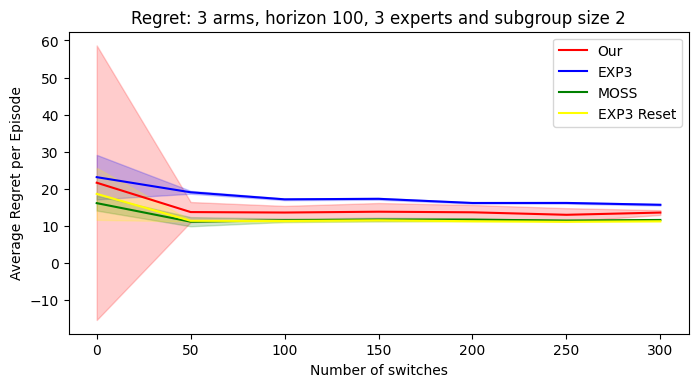

In [2]:
# utils.switches_exp(N_EXPS, N_SWITCHES, N_BANDITS, HORIZON, 
#                    N_UNBIASED_OBS, ALG_NAME, OPT_SIZE, N_EXPERT, DS_NAME, **kwargs)
# pass

## Regret vs Horizon

100%|██████████| 2/2 [01:39<00:00, 49.98s/it]


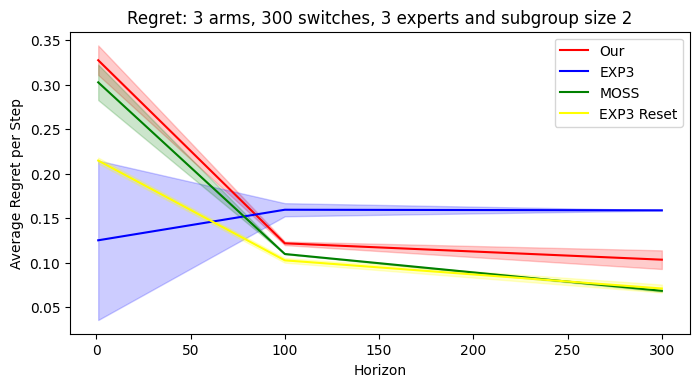

In [6]:
utils.horizon_exp(N_EXPS, N_SWITCHES, N_BANDITS, N_UNBIASED_OBS, ALG_NAME, OPT_SIZE, N_EXPERT, 
                  DS_NAME, horizon_list = np.array([1, 100, 300]), **kwargs)
pass

## Regret vs # of arm

In [8]:
# n_bandits_list = np.arange(5,21,5)
# utils.arm_exp(N_EXPS, N_SWITCHES, HORIZON, N_UNBIASED_OBS, ALG_NAME, 
#               OPT_SIZE, N_EXPERT, DS_NAME, n_bandits_list, **kwargs)
# pass

  0%|          | 0/2 [00:10<?, ?it/s]


KeyboardInterrupt: 

## Regret vs # of experts

In [ ]:
# utils.experts_exp(N_EXPS, N_SWITCHES, N_BANDITS, HORIZON, N_UNBIASED_OBS, ALG_NAME, OPT_SIZE, 
#                   DS_NAME, n_experts_list = np.arange(10,min(411,max_n_expert),20), **kwargs)
# pass

## Regret vs subgroup size

100%|██████████| 2/2 [00:24<00:00, 12.42s/it]


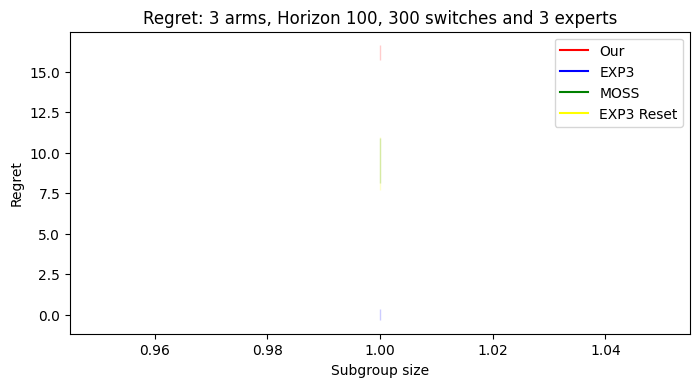

In [4]:
# utils.subgroup_size_exp(N_EXPS, N_SWITCHES, N_BANDITS, HORIZON, N_UNBIASED_OBS, ALG_NAME, N_EXPERT, 
#                         DS_NAME, opt_size_list = np.arange(1,N_BANDITS+1,4), **kwargs)
# pass

# LastFM Experiment

In [23]:
DS_NAME = 'LastFM'
N_SWITCHES = 1891 # LastFM: 1891
HORIZON = 200
COUNT_THRESHOLD = 4
N_BANDITS = 89 # LastFM: Bandit/Count_threshold = 89/4, 120/3, 240/2, 809/1
kwargs['count_threshold'] = COUNT_THRESHOLD

Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.


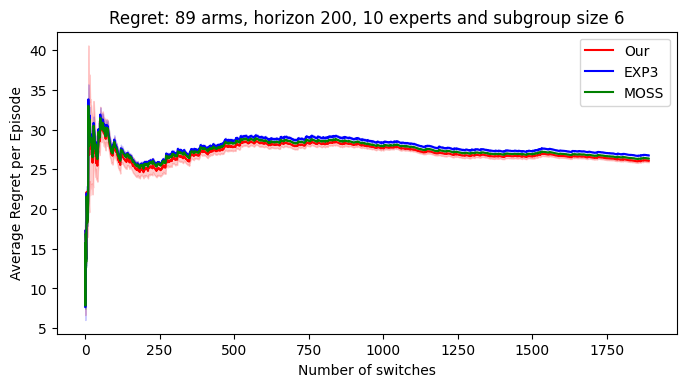

In [8]:
cache = utils.switches_exp(N_EXPS, N_SWITCHES, N_BANDITS, HORIZON, N_UNBIASED_OBS, ALG_NAME, 
                   OPT_SIZE, N_EXPERT, DS_NAME, **kwargs)

Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.


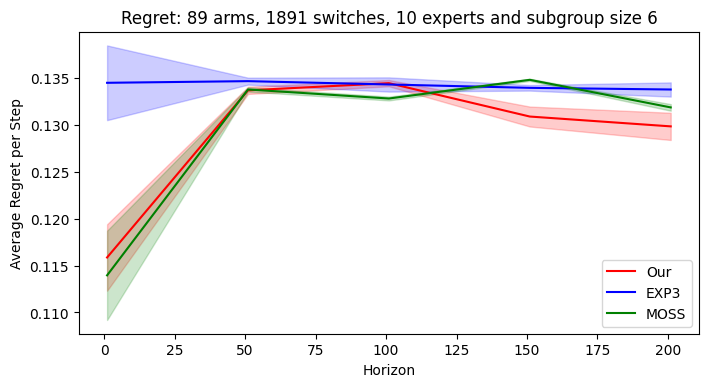

In [13]:
cache_h = utils.horizon_exp(N_EXPS, N_SWITCHES, N_BANDITS, N_UNBIASED_OBS, ALG_NAME, OPT_SIZE, N_EXPERT, 
                  DS_NAME, horizon_list = np.arange(1,202,50), quiet=True, **kwargs)

Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/

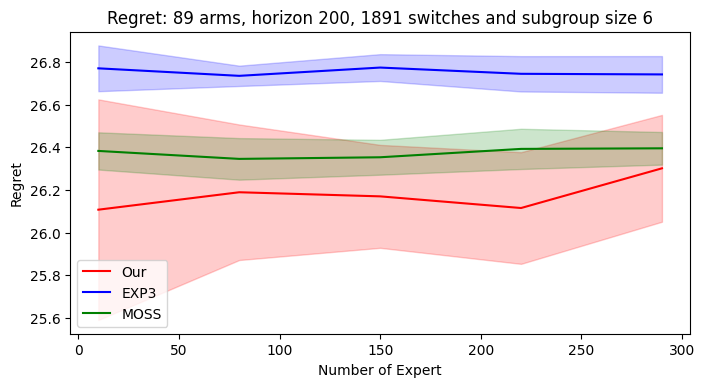

In [24]:
cache_e = utils.experts_exp(N_EXPS, N_SWITCHES, N_BANDITS, HORIZON, N_UNBIASED_OBS, ALG_NAME, OPT_SIZE, 
                  DS_NAME, n_experts_list = np.arange(10,300,70), **kwargs)

Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/17632 artists that are most favorited by more than 4/1892 people.
Keeping only 89/

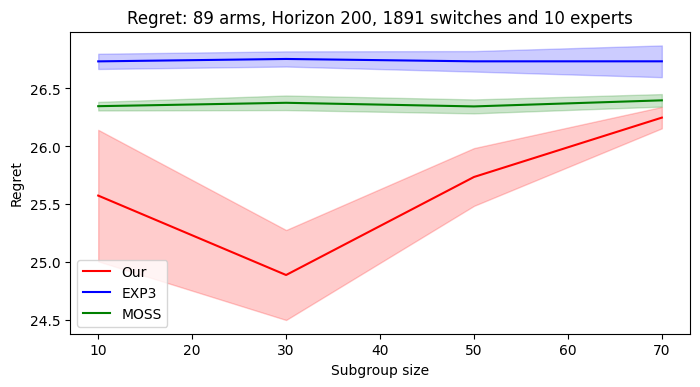

In [12]:
cache_s = utils.subgroup_size_exp(N_EXPS, N_SWITCHES, N_BANDITS, HORIZON, N_UNBIASED_OBS, ALG_NAME, N_EXPERT, 
                        DS_NAME, opt_size_list = np.arange(10,80,20), **kwargs)